In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../..'))
from PySDM.physics import si
from PySDM.initialisation.spectral_sampling import constant_multiplicity
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.formulae import volume

n_sd = 2**13
initial_spectrum = Exponential(norm_factor=8.39e12, scale=1.19e5 * si.um**3)
sampling_range = (volume(radius=10 * si.um), volume(radius=100 * si.um))
attributes = {}
attributes['volume'], attributes['n'] =\
    constant_multiplicity(n_sd=n_sd, spectrum=initial_spectrum, range=sampling_range)

/home/edejong/.conda/envs/edjPySDM/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Constant
from PySDM.backends import Numba
from PySDM.state.products.particles_volume_spectrum import ParticlesVolumeSpectrum

builder = Builder(n_sd=n_sd, backend=Numba)
builder.set_environment(Box(dt=1 * si.s, dv=1e6 * si.m**3))
builder.add_dynamic(Coalescence(kernel=Constant(kernel_const=1e-2 / si.s)))
products = [ParticlesVolumeSpectrum()]
particles = builder.build(attributes, products)

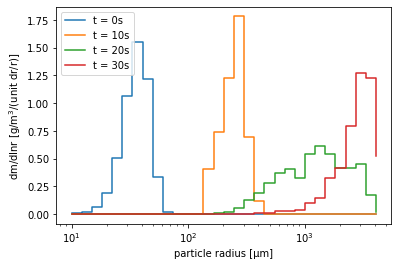

In [3]:
from PySDM.physics.constants import rho_w
from matplotlib import pyplot
import numpy as np

radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(5e3 * si.um), num=32)

for step in [0, 10, 20, 30]:
    particles.run(step - particles.n_steps)
    pyplot.step(x=radius_bins_edges[:-1] / si.um,
                y=particles.products['dv/dlnr'].get(radius_bins_edges) * rho_w / si.g,
                where='post', label=f"t = {step}s")

pyplot.xscale('log')
pyplot.xlabel('particle radius [µm]')
pyplot.ylabel("dm/dlnr [g/m$^3$/(unit dr/r)]")
pyplot.legend()
pyplot.show()